In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

In [51]:
def produce_plots(df,lb, q1=0.25,q2=0.75):
    q1 = q1
    q2 = q2
    q3 = 0.5

    means = df.groupby('iteration').mean()
    q_lower = df.groupby(by='iteration').quantile(q=q1,interpolation='lower')
    q_mid = df.groupby(by='iteration').quantile(q=q3,interpolation='linear')
    q_higher = df.groupby(by='iteration').quantile(q=q2,interpolation='higher')
    
    f = plt.figure()
    
    ax1 = f.add_subplot()

    ax1.fill_between(x=range(len(means)), y1=q_lower['Loss'], y2=q_higher['Loss'],alpha=0.4)
    ax1.plot(q_lower['Loss'], label=f'Q{int(q1*100)}',c='black')
    ax1.plot(q_higher['Loss'], label=f'Q{int(q2*100)}',c='black')
    ax1.plot(q_mid['Loss'], label=f'Q{int(q3*100)}',c='black')
    ax1.plot(means['Loss'], label='Mean')

    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    f = plt.figure()
    ax2 = f.add_subplot()

    ax2.fill_between(x=range(len(means)), y1=q_lower['C1'], y2=q_higher['C1'],alpha=0.4)
    ax2.plot(q_lower['C1'], ls = '-', label=f'Q{int(q1*100)}',c='black')
    ax2.plot(q_higher['C1'], ls = '-', label=f'Q{int(q2*100)}',c='black')
    ax2.plot(q_mid['C1'], label=f'Q{int(q3*100)}',c='black')
    ax2.plot(means['C1'], label='Mean')

    ax2.set_xlabel('Iteration')
    # ax2.set_ylim(bottom=-0.02, top=0.02)
    ax2.hlines(y=[-lb, lb], xmin=0, xmax=len(means), ls='--',colors='blue', alpha=0.5, label='Constraint bound')
    ax2.hlines(y=0, xmin=0, xmax=len(means), ls='--', colors='black', alpha=0.5)
    ax2.set_ylabel('$L_w-L_b$')
    ax2.legend()
    
    plt.show()

In [ ]:
DATASET = 'employment_az'
lb = 0.005
geomp = 0.05
sampling = 1
alg = 'sg'

if alg in ['sg', 'sg_oe']:
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}_p{geomp}_REPORT.csv'
else:
    filename = f'./src/experiments/utils/exp_results/{alg}_' + f'{DATASET}_{lb}_{sampling}_REPORT.csv'

In [63]:
stats = pd.read_csv(filename)
stats_train = stats[stats['is_train'] == 'train'].drop(['is_train'], axis=1)
stats_test = stats[stats['is_train'] == 'test'].drop(['is_train'], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: './src/experiments/utils/exp_results/sg_employment_az_0.005_p0.05_REPORT.csv'

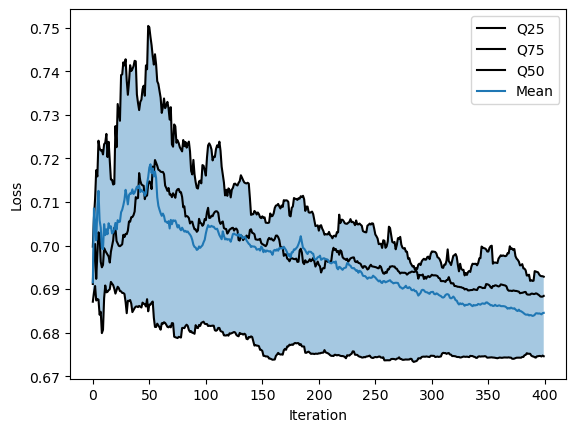

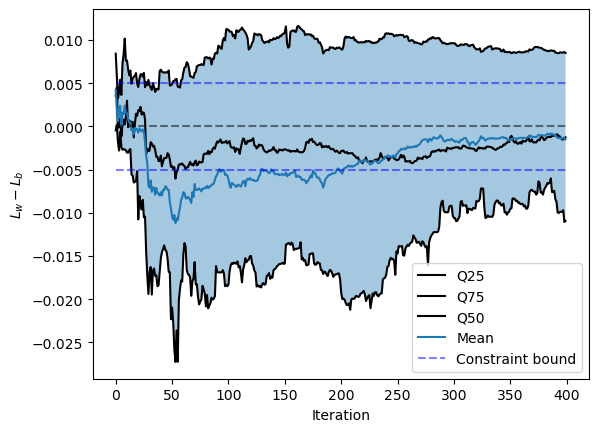

In [ ]:
produce_plots(stats_train, lb)

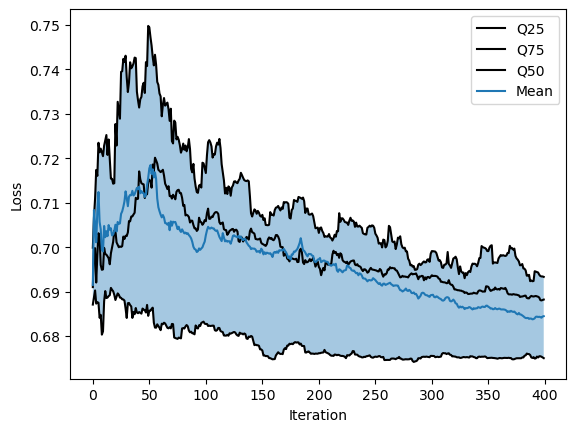

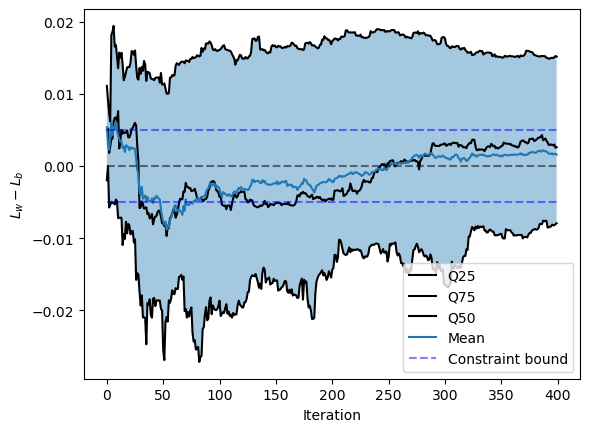

In [ ]:
produce_plots(stats_test, lb)

will add other plots (optimal threshold, etc) later